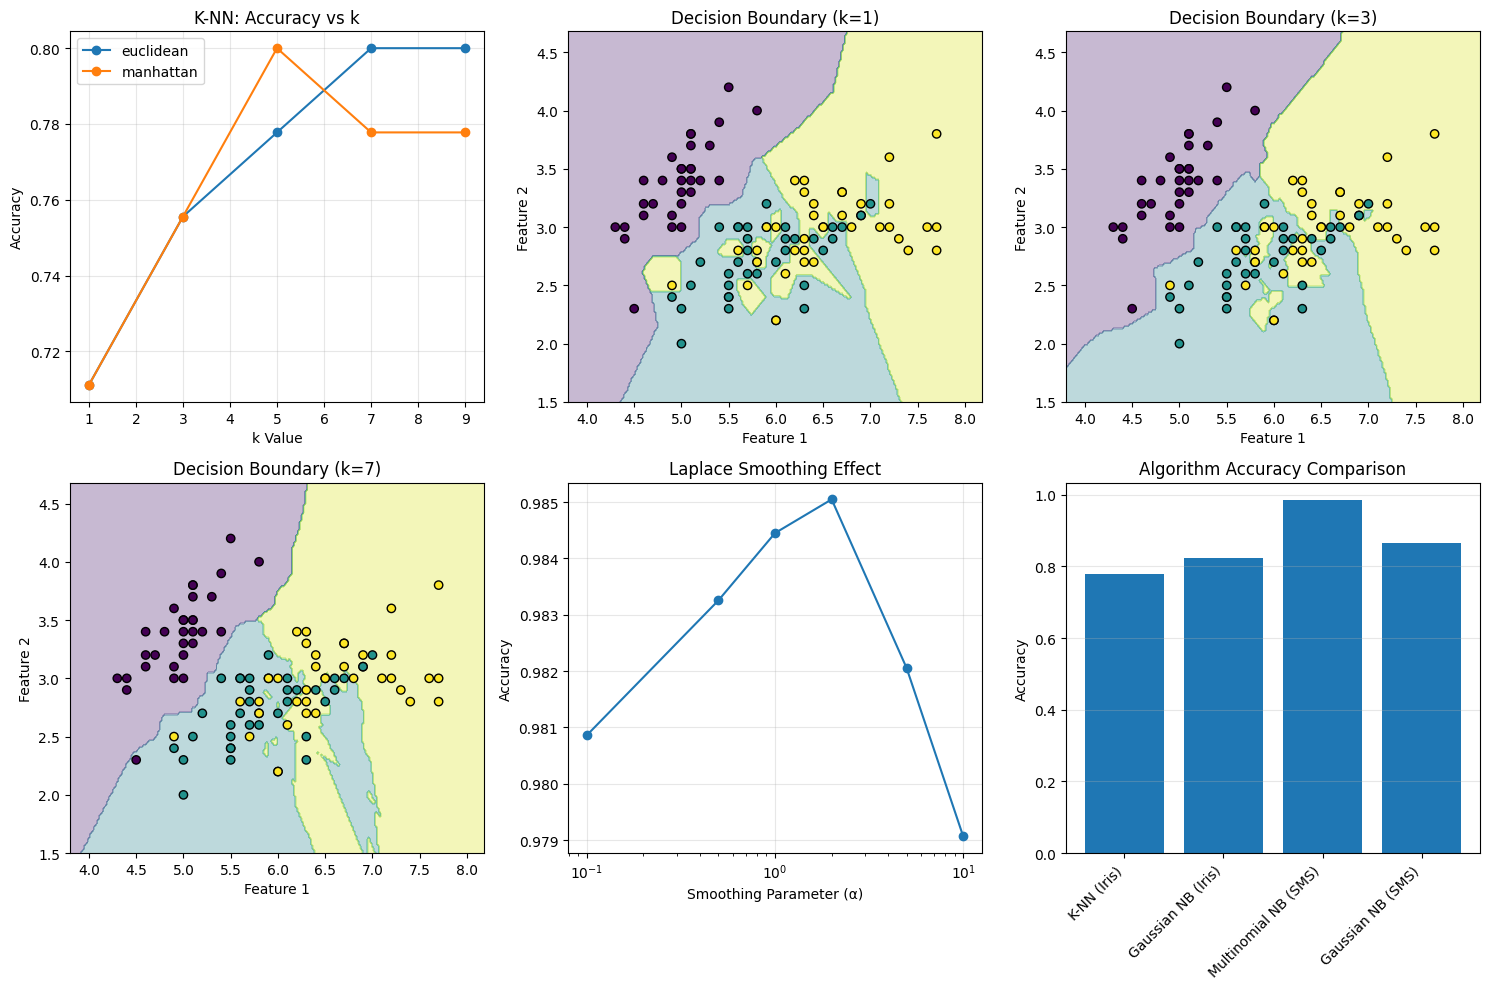

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import string

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


# LOAD DATASETS

iris = load_iris()
X_iris = iris.data[:, :2]     # Only 2 features for visualization
y_iris = iris.target

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)

# Load SMS dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df_sms = pd.read_csv(url, sep='\t', names=['label', 'message'])

df_sms['label'] = df_sms['label'].map({'ham':0, 'spam':1})
df_sms['processed'] = df_sms['message'].str.lower().str.replace(
    f"[{string.punctuation}]", "", regex=True)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    df_sms['processed'], df_sms['label'], test_size=0.3, random_state=42
)

vectorizer = CountVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train_s)
X_test_vec = vectorizer.transform(X_test_s)

X_train_num = np.array([[len(msg), len(msg.split())] for msg in X_train_s])
X_test_num = np.array([[len(msg), len(msg.split())] for msg in X_test_s])


# CREATE SINGLE FIGURE WITH 6 SUBPLOTS


plt.figure(figsize=(15,10))


#  Accuracy vs K


plt.subplot(2,3,1)

k_values = [1,3,5,7,9]
for metric in ['euclidean', 'manhattan']:
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_i, y_train_i)
        acc = accuracy_score(y_test_i, knn.predict(X_test_i))
        accuracies.append(acc)

    plt.plot(k_values, accuracies, marker='o', label=metric)

plt.title("K-NN: Accuracy vs k")
plt.xlabel("k Value")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)


# Decision Boundaries


for idx, k in enumerate([1,3,7], start=2):
    plt.subplot(2,3,idx)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_i, y_train_i)

    x_min, x_max = X_train_i[:,0].min()-0.5, X_train_i[:,0].max()+0.5
    y_min, y_max = X_train_i[:,1].min()-0.5, X_train_i[:,1].max()+0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),
        np.arange(y_min, y_max, 0.02)
    )

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_i[:,0], X_train_i[:,1], c=y_train_i, edgecolor='k')

    plt.title(f"Decision Boundary (k={k})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

#  Laplace Smoothing Effect

plt.subplot(2,3,5)

alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
accuracies = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_vec, y_train_s)
    acc = accuracy_score(y_test_s, model.predict(X_test_vec))
    accuracies.append(acc)

plt.plot(alphas, accuracies, marker='o')
plt.xscale('log')
plt.title("Laplace Smoothing Effect")
plt.xlabel("Smoothing Parameter (α)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

#  Algorithm Accuracy Comparison

plt.subplot(2,3,6)

# Train models
knn_iris = KNeighborsClassifier(n_neighbors=5)
knn_iris.fit(X_train_i, y_train_i)
acc_knn_iris = accuracy_score(y_test_i, knn_iris.predict(X_test_i))

gnb_iris = GaussianNB()
gnb_iris.fit(X_train_i, y_train_i)
acc_gnb_iris = accuracy_score(y_test_i, gnb_iris.predict(X_test_i))

mnb_sms = MultinomialNB()
mnb_sms.fit(X_train_vec, y_train_s)
acc_mnb_sms = accuracy_score(y_test_s, mnb_sms.predict(X_test_vec))

gnb_sms = GaussianNB()
gnb_sms.fit(X_train_num, y_train_s)
acc_gnb_sms = accuracy_score(y_test_s, gnb_sms.predict(X_test_num))

labels = [
    "K-NN (Iris)",
    "Gaussian NB (Iris)",
    "Multinomial NB (SMS)",
    "Gaussian NB (SMS)"
]

accuracies = [
    acc_knn_iris,
    acc_gnb_iris,
    acc_mnb_sms,
    acc_gnb_sms
]

plt.bar(labels, accuracies)
plt.xticks(rotation=45,ha='right')
plt.title("Algorithm Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()